In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import spectrogram

In [125]:
import warnings
warnings.filterwarnings("ignore")

In [126]:
filename = './exchange_data/BTC_1h_return.csv'
data = pd.read_csv(filename, parse_dates=True)
data['Date'] = pd.to_datetime(data['Date'])

In [127]:
data

,Date,Return
0,2019-02-28 01:00:00,0.000063
1,2019-02-28 02:00:00,-0.002823
2,2019-02-28 03:00:00,0.000427
3,2019-02-28 04:00:00,0.001800
4,2019-02-28 05:00:00,0.001208
...,...,...
18210,2021-03-29 19:00:00,-0.002483
18211,2021-03-29 20:00:00,-0.006923
18212,2021-03-29 21:00:00,0.004722
18213,2021-03-29 22:00:00,0.003465


In [128]:
def gabor_filter(data, width, freq, causal=False):
    """
    Apply a Gabor filter to the data.

    Parameters:
        data (pd.DataFrame): The input DataFrame with 'Date' and 'Return' columns.
        fs (float): Sampling frequency.
        width (float): Width of the Gabor filter in the time domain.
        freq (float): Center frequency of the Gabor filter.
        causal (bool): If True, make the filter causal.

    Returns:
        np.ndarray: The filtered data.
        pd.Series: The datetime values for plotting.
    """
    t = (data['Date'].astype(int) // 10**9).values # convert datetime to unix timestamp in seconds
    x = data['Return'].values

    timesteps = len(x)
    ts = np.linspace(t[0], t[-1], timesteps, dtype=np.float64)
    gabor_filter = signal.gaussian(timesteps, std=width)
    gabor_filter /= np.sum(gabor_filter)
    gabor_filter = gabor_filter * np.exp(2j * np.pi * freq * ts)

    if causal:
        mid_point = len(gabor_filter) // 2
        gabor_filter[:mid_point] = 0
        gabor_filter /= np.sum(np.abs(gabor_filter))

    filtered_x = signal.convolve(x, gabor_filter, mode='same')

    return filtered_x, pd.to_datetime(t, unit='s')

In [129]:
def plot_filtered_data(t, x, filtered_x):
    """
    Plot the original and filtered data.

    Parameters:
        t (pd.Series): The datetime values for plotting.
        x (np.ndarray): The original data.
        filtered_x (np.ndarray): The filtered data.

    Returns:
        None
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.plot(t, x, label='Unfiltered data')
    ax.plot(t, np.real(filtered_x), label='Filtered data')
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Return')
    ax.set_title('Gabor filtering of data')
    plt.show()
    # fig.savefig('./wavelets/gabor_1h.jpg', dpi=300)

In [130]:
def plot_spectrogram(filtered_x, fs, window_size, overlap):
    """
    Plot the spectrogram of the filtered data.

    Parameters:
        filtered_x (np.ndarray): The filtered data.
        fs (float): Sampling frequency.
        window_size (int):  Length of window for each Gabor transform, A larger window_size     
        provides better frequency resolution but worse time resolution.
        overlap (float): Overlap fraction for the spectrogram. Overlap fraction between consecutive windows.

    Returns:
        None
    """
    # Generate the spectrogram of the filtered data
    f, t_spec, Sxx = spectrogram(filtered_x, fs=fs, window='hann', nperseg=window_size, noverlap=int(window_size * overlap), scaling='spectrum')

    t_spec /= 3600 #  hour
    
    # Create the figure
    fig = plt.figure(figsize=(12, 12))

    # Plot the spectrogram
    plt.pcolormesh(t_spec, f, np.log10(Sxx), cmap='jet')
    plt.xlabel('Time (hour)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Log power spectral density')

    plt.show()

In [159]:
window_size = 24*7 # weekly
overlap = 0.0
fs = 1 / (data['Date'][1] - data['Date'][0]).seconds
width = 1 # sigma_t * sigma_f = 1
freq = 1e-4 # it should be less than the Nyquist frequency fs/2

In [160]:
fs

0.0002777777777777778

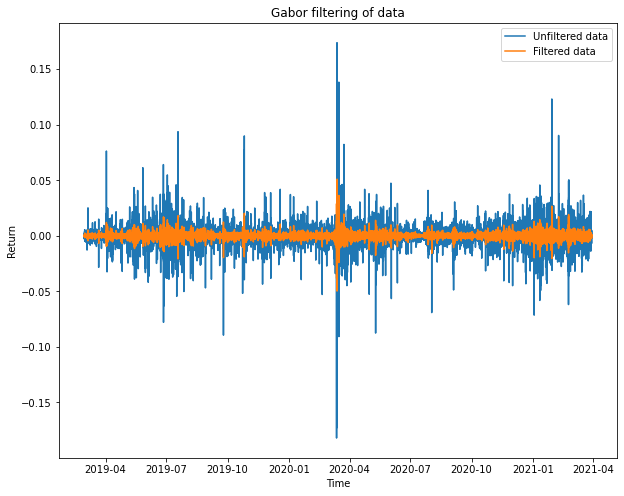

In [161]:
filtered_x, t = gabor_filter(data, width, freq, causal=False)
plot_filtered_data(t, data['Return'], filtered_x)

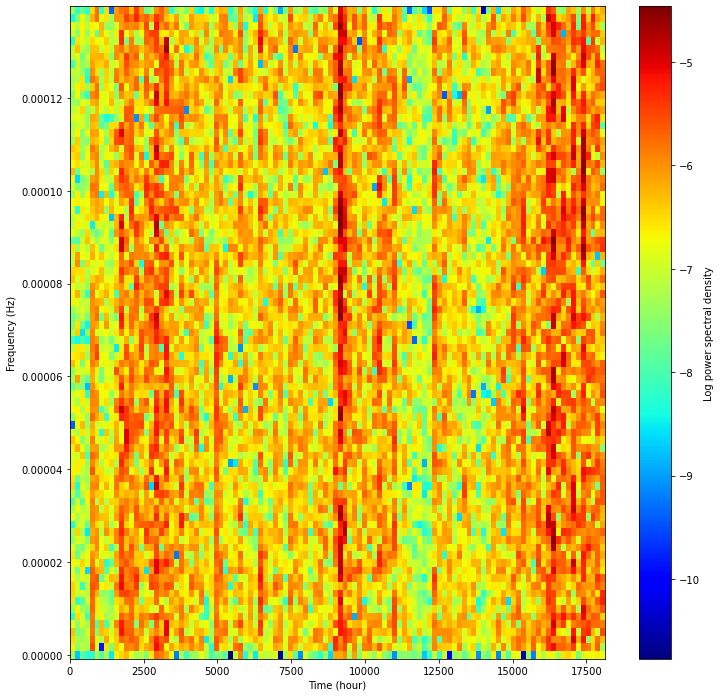

In [162]:
# without filtering
plot_spectrogram(data['Return'], fs, window_size, overlap)

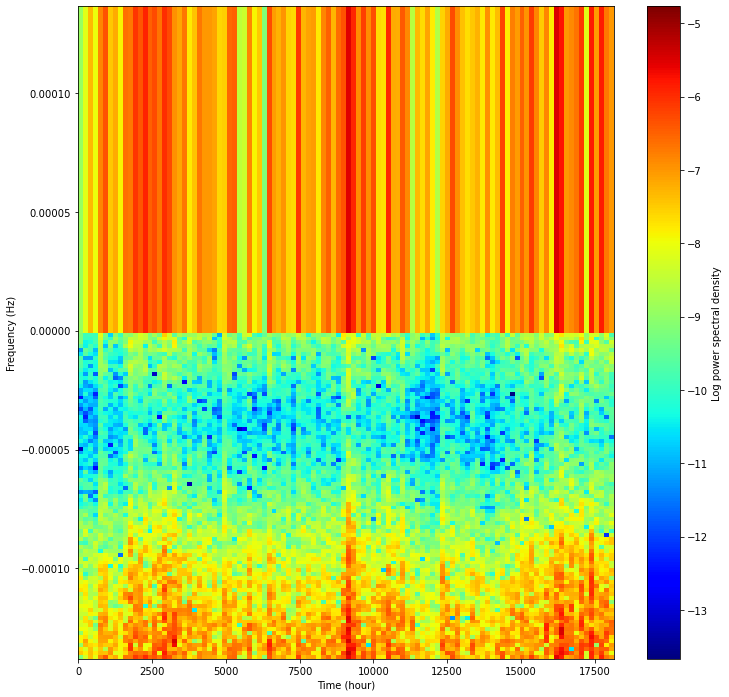

In [163]:
# oversight due to non-causal filtering scheme (t-dt, t+dt)
plot_spectrogram(filtered_x, fs, window_size, overlap)

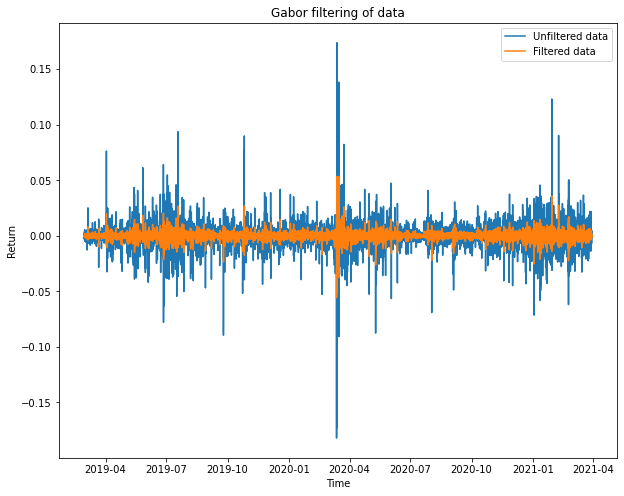

In [164]:
filtered_x, t = gabor_filter(data, width, freq, causal=True)
plot_filtered_data(t, data['Return'].values, filtered_x)

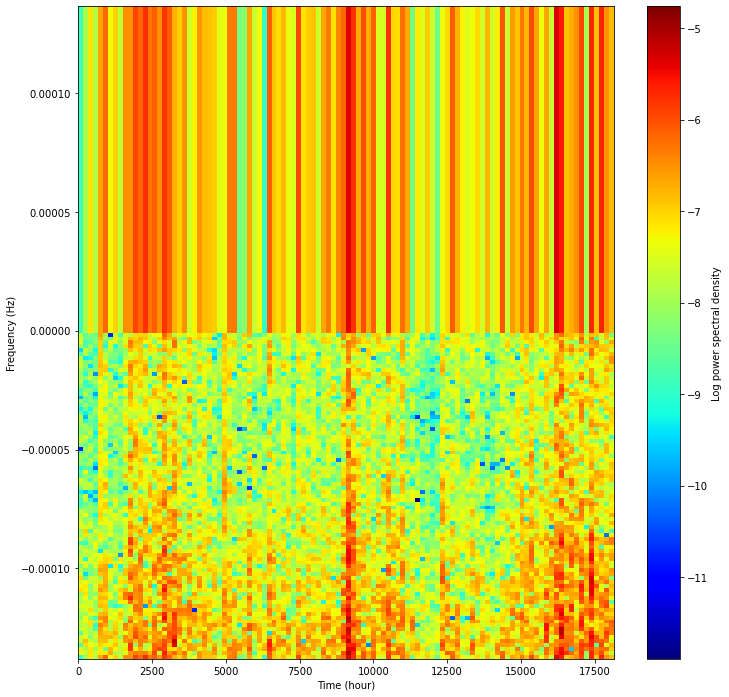

In [165]:
# causal (t-dt, t)
# all the freq < 0 (dt<0) are masked to 0
plot_spectrogram(filtered_x, fs, window_size, overlap)